In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time
import csv
from astropy.io import ascii
import pandas as pd
import pickle

from mpl_toolkits.mplot3d import Axes3D


import os
Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline


In [2]:
df_norma_askap = pd.read_pickle('decomposition_results/ASKAP/norma_askap_final.pkl')
df_hydra_askap = pd.read_pickle('decomposition_results/ASKAP/hydra_askap_final.pkl')
df_normaV2_atca = pd.read_pickle('decomposition_results/ATCA/norma_atca_0.2kms_final.pkl')
df_norma4k_atca = pd.read_pickle('decomposition_results/ATCA/norma_atca_4kms_final.pkl')
df_hydraV2_atca = pd.read_pickle('decomposition_results/ATCA/hydra_atca_0.2kms_final.pkl')
df_hydra4k_atca = pd.read_pickle('decomposition_results/ATCA/hydra_atca_4kms_final.pkl')

In [3]:


ra_deg_hv2_atca_all  = np.array(df_hydraV2_atca['ra (deg)'])
dec_deg_hv2_atca_all  = np.array(df_hydraV2_atca['dec (deg)'])
ra_deg_h4k_atca_all  = np.array(df_hydra4k_atca['ra (deg)'])
dec_deg_h4k_atca_all  = np.array(df_hydra4k_atca['dec (deg)'])

centre_h = '10:29:00, -27:35:25'
coordinate_h = centre_h.replace(',', '')
c_h = SkyCoord(coordinate_h, unit=(u.hourangle, u.deg))
path_hi_h = SkyView.get_images(position=centre_h, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi_h = path_hi_h[0]


ra_deg_nv2_atca_all  = np.array(df_normaV2_atca['ra (deg)'])
dec_deg_nv2_atca_all  = np.array(df_normaV2_atca['dec (deg)'])
ra_deg_n4k_atca_all  = np.array(df_norma4k_atca['ra (deg)'])
dec_deg_n4k_atca_all  = np.array(df_norma4k_atca['dec (deg)'])

centre_n = '16:38:00, -59:50:00'
coordinate_n = centre_n.replace(',', '')
c_n = SkyCoord(coordinate_n, unit=(u.hourangle, u.deg))
path_hi_n = SkyView.get_images(position=centre_n, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi_n = path_hi_n[0]


In [6]:
ra_h_askap = np.array(df_hydra_askap['ra (hms)'])
dec_h_askap = np.array(df_hydra_askap['dec (dms)'])
ra_deg_h_askap = np.array(df_hydra_askap['ra (deg)'])
dec_deg_h_askap = np.array(df_hydra_askap['dec (deg)'])

ra_n_askap = np.array(df_norma_askap['ra (hms)'])
dec_n_askap = np.array(df_norma_askap['dec (dms)'])
ra_deg_n_askap = np.array(df_norma_askap['ra (deg)'])
dec_deg_n_askap = np.array(df_norma_askap['dec (deg)'])


In [7]:
df_norma_askap.head()

,source,ra (deg),dec (deg),ra (hms),dec (dms),amp,e_amp,VLSR,e_VLSR,vel_disp,...,pvalue,aicc,rchi2,ncomps,ncomp_wmedian,ncomp_jumps,flag_blended,flag_neg_res_peak,flag_broad,flag_centroid
0,165201.3-581710,253.005417,-58.286111,16:52:01.3,-58:17:10,0.0901,0.0288,1.223100,0.3426,3.2703,...,0.0507,-1459.7280,1.2636,2,1,0,0,0,0,0
1,165201.3-581710,253.005417,-58.286111,16:52:01.3,-58:17:10,0.0899,0.0102,-9.889700,0.2902,2.6189,...,0.0507,-1459.7280,1.2636,2,1,0,0,0,0,0
2,164533.5-570200,251.389583,-57.033333,16:45:33.5,-57:02:00,0.9765,0.0155,0.229860,0.0758,2.0765,...,0.0018,-910.4408,1.2984,2,1,0,0,0,0,0
3,164533.5-570200,251.389583,-57.033333,16:45:33.5,-57:02:00,0.0926,0.0430,-8.907440,0.4340,2.3432,...,0.0018,-910.4408,1.2984,2,1,0,0,0,0,0
4,171143.0-613251,257.929167,-61.547500,17:11:43.0,-61:32:51,1.4231,0.0724,3.929736,0.2443,1.8929,...,0.0149,-595.3508,0.8544,1,1,0,0,0,0,0


In [11]:
def plot_tau_gal(df, arr_ar, arr_dec):
    # Assuming tau values are already in the dataframe as 'amp' (optical depth)
    tau = np.array(df['amp'])
    
    # Convert RA/Dec to Galactic coordinates
    coords = SkyCoord(ra=arr_ar*u.deg, dec=arr_dec*u.deg, frame='icrs')
    galactic_coords = coords.galactic
    galactic_lat = galactic_coords.b.deg
    
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(galactic_lat, tau, c='blue', edgecolor='black', s=40, alpha=0.75)
    
    # Styling the plot for a publication-quality figure
    plt.title('Optical Depth vs Galactic Latitude', fontsize=16)
    plt.xlabel('Galactic Latitude (degrees)', fontsize=14)
    plt.ylabel('Optical Depth (Tau)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.xlim([-90, 90])  # Setting limits for Galactic latitude
    plt.ylim([0, np.max(tau) * 1.1])  # Setting limits for Tau
    plt.tight_layout()
    
    # Show plot
    plt.show()

In [41]:
def plot_tau_gal_comparison(df1, arr_ar1, arr_dec1,df2, arr_ar2, arr_dec2,df3, arr_ar3, arr_dec3, xlim = None, ylim = None):
    # Assuming tau values are already in the dataframe as 'amp' (optical depth)
    tau1 = np.array(df1['amp'])
    
    # Convert RA/Dec to Galactic coordinates
    coords1 = SkyCoord(ra=arr_ar1*u.deg, dec=arr_dec1*u.deg, frame='icrs')
    galactic_coords1 = coords1.galactic
    galactic_lat1 = galactic_coords1.b.deg

    tau2 = np.array(df2['amp'])
    
    # Convert RA/Dec to Galactic coordinates
    coords2 = SkyCoord(ra=arr_ar2*u.deg, dec=arr_dec2*u.deg, frame='icrs')
    galactic_coords2 = coords2.galactic
    galactic_lat2 = galactic_coords2.b.deg

    tau3 = np.array(df3['amp'])
    
    # Convert RA/Dec to Galactic coordinates
    coords3 = SkyCoord(ra=arr_ar3*u.deg, dec=arr_dec3*u.deg, frame='icrs')
    galactic_coords3 = coords3.galactic
    galactic_lat3 = galactic_coords3.b.deg
    
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(galactic_lat1, tau1, c='blue', edgecolor='black', s=60, alpha=0.75, label = "ASKAP")
    plt.scatter(galactic_lat2, tau2, c='red', edgecolor='red', s=60, alpha=0.75, label = "ATCA 0.2")
    plt.scatter(galactic_lat3, tau3, c='green', edgecolor='black', s=60, alpha=0.75, label = "ATCA 4")
    
    # Styling the plot for a publication-quality figure
    plt.title('Optical Depth vs Galactic Latitude', fontsize=16)
    plt.xlabel('Galactic Latitude (degrees)', fontsize=14)
    plt.ylabel('Optical Depth (Tau)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if xlim != None:
        plt.xlim([xlim[0], xlim[1]])  # Setting limits for Galactic latitude
    #plt.ylim([0, np.max(tau1) * 1.1])  # Setting limits for Tau
    plt.tight_layout()
    plt.legend()
    
    # Show plot
    plt.show()

### Norma

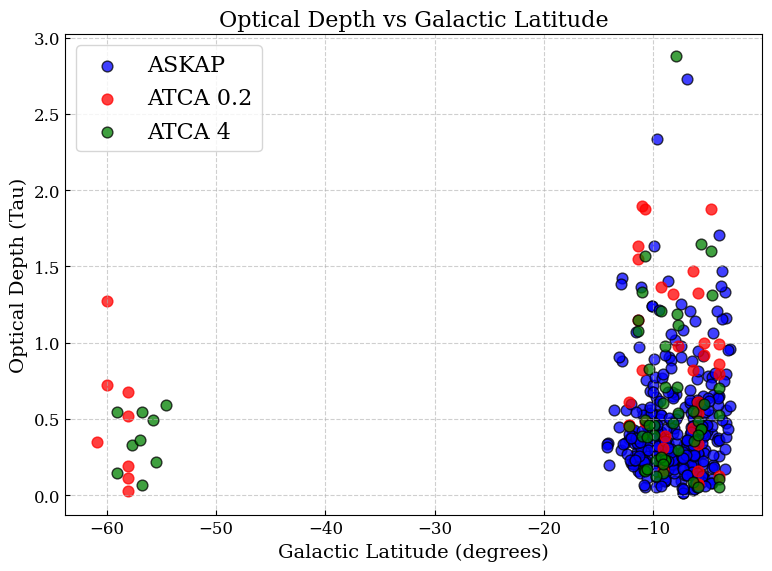

In [44]:
plot_tau_gal_comparison(df_norma_askap, ra_deg_n_askap, dec_deg_n_askap,
                        df_normaV2_atca, ra_deg_nv2_atca_all, dec_deg_nv2_atca_all,
                        df_norma4k_atca, ra_deg_n4k_atca_all, dec_deg_n4k_atca_all, 
                        xlim = None)

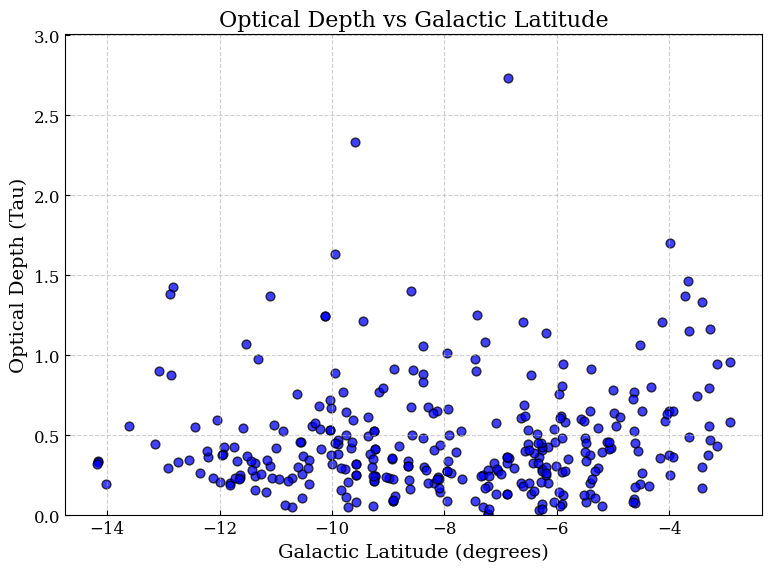

In [13]:
plot_tau_gal(df_norma_askap, ra_deg_n_askap, dec_deg_n_askap)

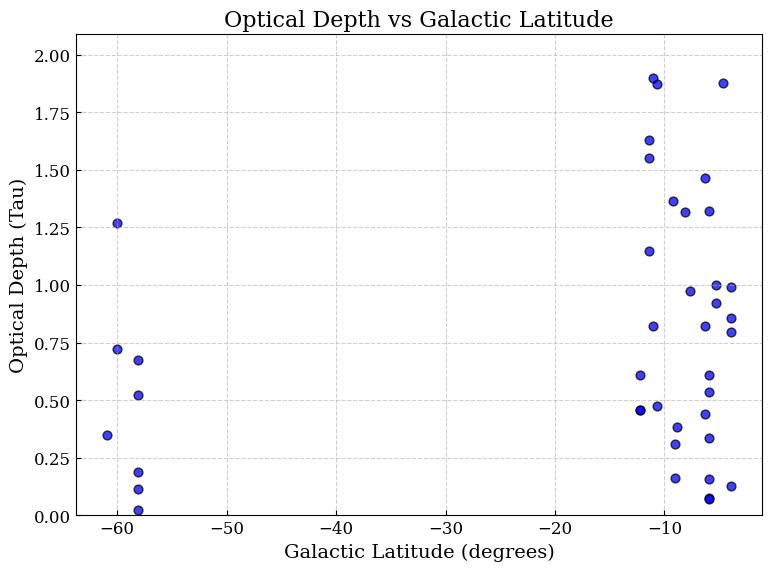

In [12]:
plot_tau_gal(df_normaV2_atca, ra_deg_nv2_atca_all, dec_deg_nv2_atca_all)

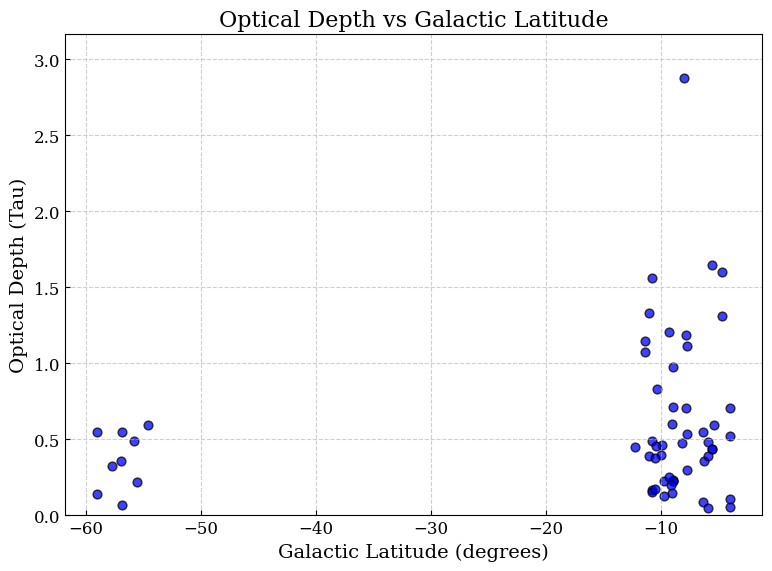

In [15]:
plot_tau_gal(df_norma4k_atca, ra_deg_n4k_atca_all, dec_deg_n4k_atca_all)

### Hydra

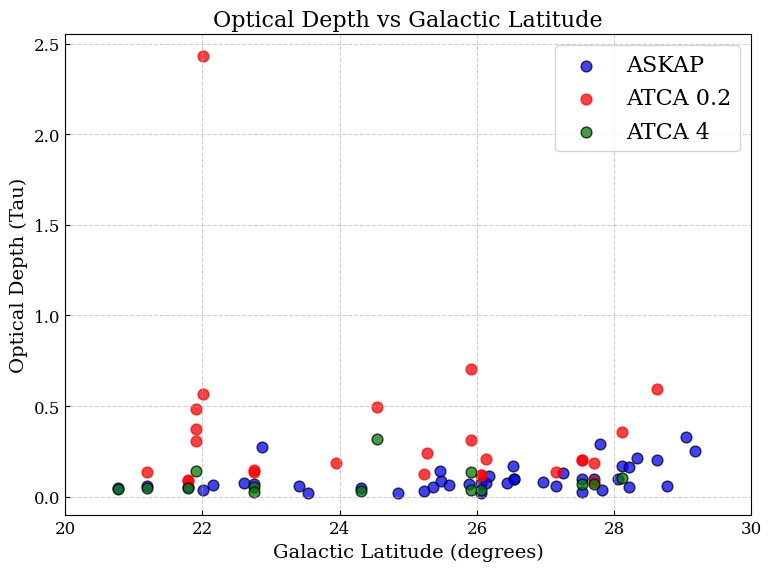

In [42]:
plot_tau_gal_comparison(df_hydra_askap, ra_deg_h_askap, dec_deg_h_askap,
                        df_hydraV2_atca, ra_deg_hv2_atca_all, dec_deg_hv2_atca_all,
                        df_hydra4k_atca, ra_deg_h4k_atca_all, dec_deg_h4k_atca_all, 
                        xlim = (20,30))

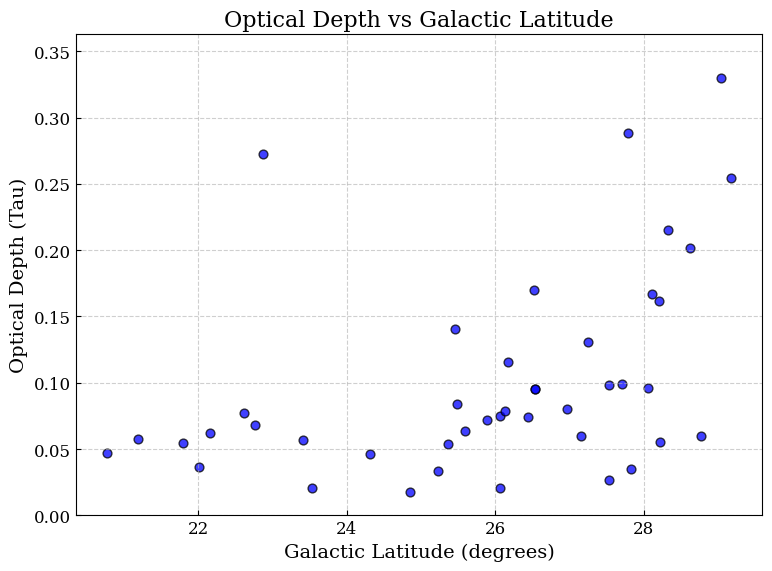

In [16]:
plot_tau_gal(df_hydra_askap, ra_deg_h_askap, dec_deg_h_askap)

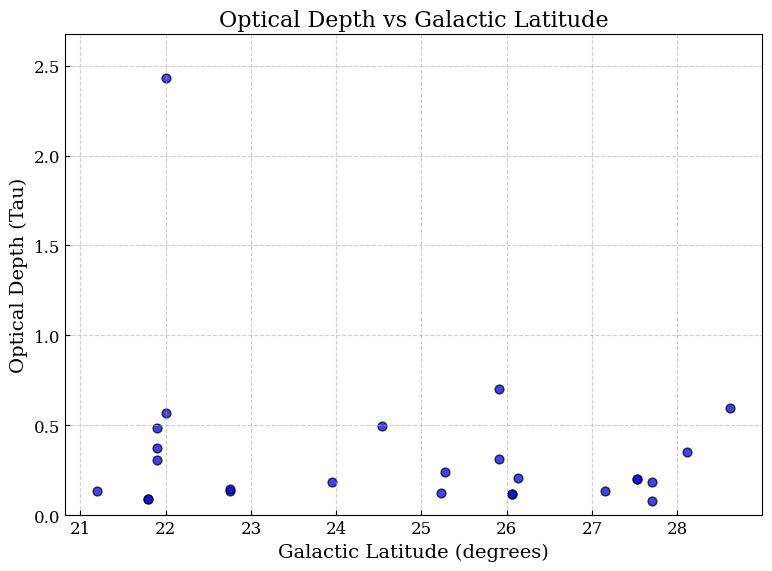

In [17]:
plot_tau_gal(df_hydraV2_atca, ra_deg_hv2_atca_all, dec_deg_hv2_atca_all)

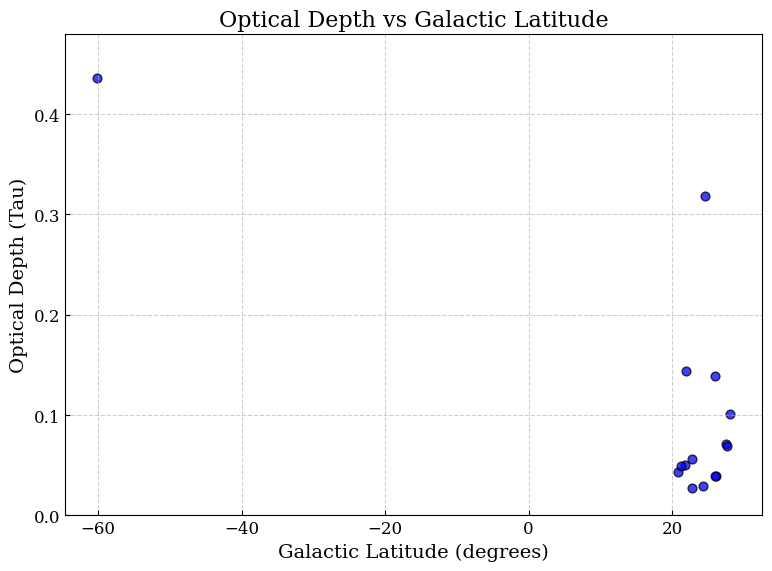

In [18]:
plot_tau_gal(df_hydra4k_atca, ra_deg_h4k_atca_all, dec_deg_h4k_atca_all)

### HI Column

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from matplotlib.colors import Normalize

def plot_continuum_tau(hdulist_hi, ra_deg, dec_deg, tau, tau_range):
    """
    Parameters:
    - hdulist_hi: HDU list from the FITS file.
    - ra_deg, dec_deg: RA, Dec values for points.
    - tau: Optical depth values corresponding to RA/Dec.
    - tau_range: Tuple (min, max) indicating the range of tau values to plot in green.
    - title: The title of the plot.
    """
    # Extract data and header from the FITS HDU list
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header

    # Normalize tau values (for a common color scale)
    norm = Normalize(vmin=np.min(tau), vmax=np.max(tau))

    # Create figure and WCS projection
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection=WCS(h))

    # Display the moment map image
    im = ax.imshow(d, cmap='plasma', vmax=np.percentile(d, 99.9))

    # Get limits for consistent scaling
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # Plot all tau values in white color (background scatter plot)
    ax.scatter(ra_deg, dec_deg, transform=ax.get_transform('fk5'), 
               marker='o', s=150, linewidth=1.5, edgecolor='k', 
               c='white', alpha=0.8)

    # Filter tau values within the specified range for bright green points
    in_range = (tau >= tau_range[0]) & (tau <= tau_range[1])
    
    # Plot the points within the tau range in green
    ax.scatter(ra_deg[in_range], dec_deg[in_range], transform=ax.get_transform('fk5'),
               marker='o', s=150, linewidth=1.5, edgecolor='k', 
               c='lime', alpha=0.8, label=f'Tau in range {tau_range[0]} to {tau_range[1]}')

    # Set axis labels and ticks
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

    # Add colorbar for the background image (N(HI))
    cbar_hi = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.022, pad=0.15, location='left')
    cbar_hi.set_label('N(HI)', size=18)

    # Overlay with galactic coordinates and grid
    overlay = ax.get_coords_overlay('galactic')
    overlay.grid(color='k', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
    overlay[1].set_axislabel('Galactic Latitude', fontsize=22)
    overlay[0].tick_params(axis='both', which='major', labelsize=18)
    overlay[1].tick_params(axis='both', which='major', labelsize=18)

    # Set title and legend
    ax.legend(loc='upper right', fontsize=16)

    # Keep original x/y limits
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    # Show the plot
    plt.show()

# Example of calling the function
# plot_continuum_tau(hdulist_hi, ra_deg, dec_deg, tau, (0.5, 1.5), "Optical Depth with Tau Range Highlight")


In [65]:
def plot_continuum_tau_combined(hdulist_hi, ra_deg, dec_deg, tau, tau_range, tau_range2):
    """
    Parameters:
    - hdulist_hi: HDU list from the FITS file.
    - ra_deg, dec_deg: RA, Dec values for points.
    - tau: Optical depth values corresponding to RA/Dec.
    - tau_range: Tuple (min, max) indicating the range of tau values to plot in green.
    - title: The title of the plot.
    """
    # Extract data and header from the FITS HDU list
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header

    # Normalize tau values (for a common color scale)
    norm = Normalize(vmin=np.min(tau), vmax=np.max(tau))

    # Create figure and WCS projection
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection=WCS(h))

    # Display the moment map image
    im = ax.imshow(d, cmap='plasma', vmax=np.percentile(d, 99.9))

    # Get limits for consistent scaling
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # Plot all tau values in white color (background scatter plot)
    ax.scatter(ra_deg, dec_deg, transform=ax.get_transform('fk5'), 
               marker='o', s=150, linewidth=1.5, edgecolor='k', 
               c='white', alpha=0.8)

    # Filter tau values within the specified range for bright green points
    in_range = (tau >= tau_range[0]) & (tau <= tau_range[1])
    in_range2 = (tau >= tau_range2[0]) & (tau <= tau_range2[1])
    
    # Plot the points within the tau range in green
    ax.scatter(ra_deg[in_range], dec_deg[in_range], transform=ax.get_transform('fk5'),
               marker='o', s=150, linewidth=1.5, edgecolor='k', 
               c='lime', alpha=0.8, label=f'Tau in range {tau_range[0]} to {tau_range[1]}')

        # Plot the points within the tau range in green
    ax.scatter(ra_deg[in_range2], dec_deg[in_range2], transform=ax.get_transform('fk5'),
               marker='o', s=150, linewidth=1.5, edgecolor='k', 
               c='cyan', alpha=0.8, label=f'Tau in range {tau_range2[0]} to {tau_range2[1]}')

    # Set axis labels and ticks
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

    # Add colorbar for the background image (N(HI))
    cbar_hi = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.022, pad=0.15, location='left')
    cbar_hi.set_label('N(HI)', size=18)

    # Overlay with galactic coordinates and grid
    overlay = ax.get_coords_overlay('galactic')
    overlay.grid(color='k', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
    overlay[1].set_axislabel('Galactic Latitude', fontsize=22)
    overlay[0].tick_params(axis='both', which='major', labelsize=18)
    overlay[1].tick_params(axis='both', which='major', labelsize=18)

    # Set title and legend
    ax.legend(loc='lower left', fontsize=16)

    # Keep original x/y limits
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    # Show the plot
    plt.show()

In [ ]:
plot_continuum_tau_combined(hdulist_hi_h, 
                   ra_deg_h_askap, 
                   dec_deg_h_askap, 
                   df_hydra_askap['VLSR'], 
                   (-2,5),
                   )

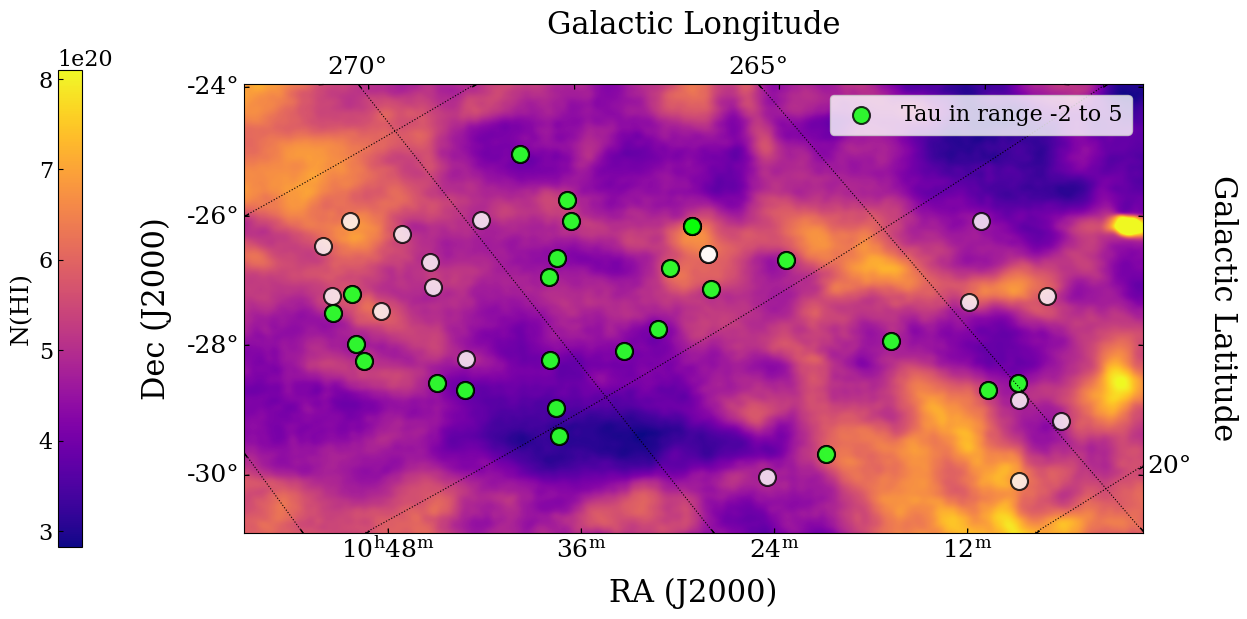

In [49]:
plot_continuum_tau(hdulist_hi_h, 
                   ra_deg_h_askap, 
                   dec_deg_h_askap, 
                   df_hydra_askap['VLSR'], 
                   (-2,5),
                   )

###  Norma

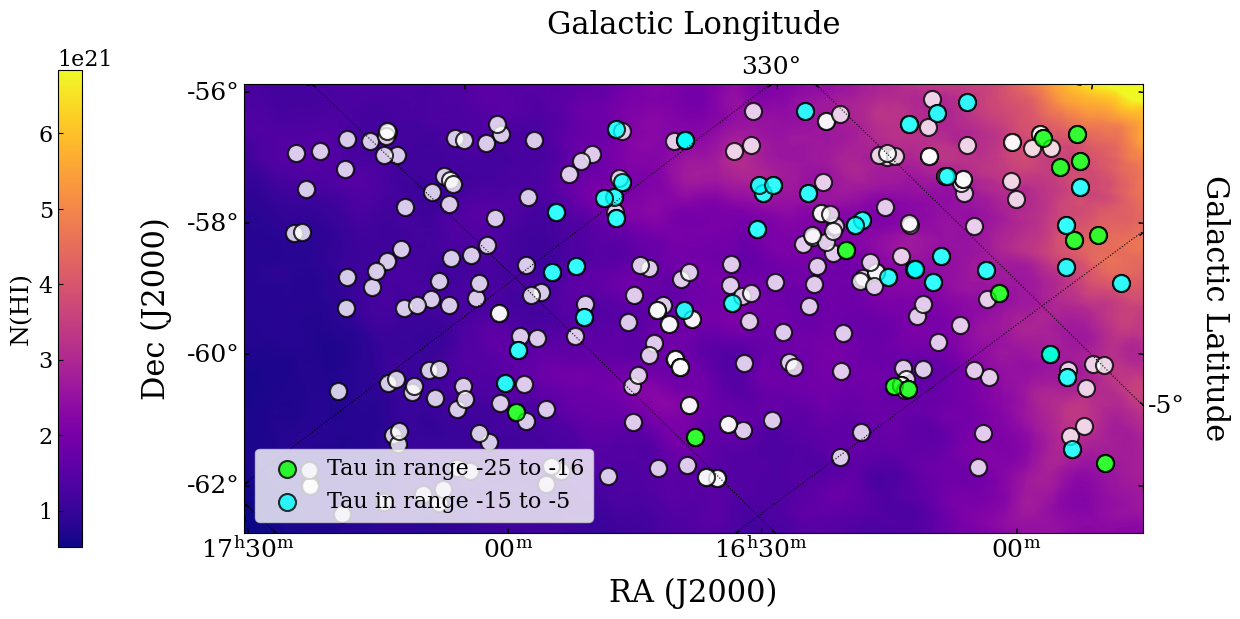

In [66]:
plot_continuum_tau_combined(hdulist_hi_n, 
                   ra_deg_n_askap, 
                   dec_deg_n_askap, 
                   df_norma_askap['VLSR'], 
                   (-25,-16),
                   (-15,-5),
                   )

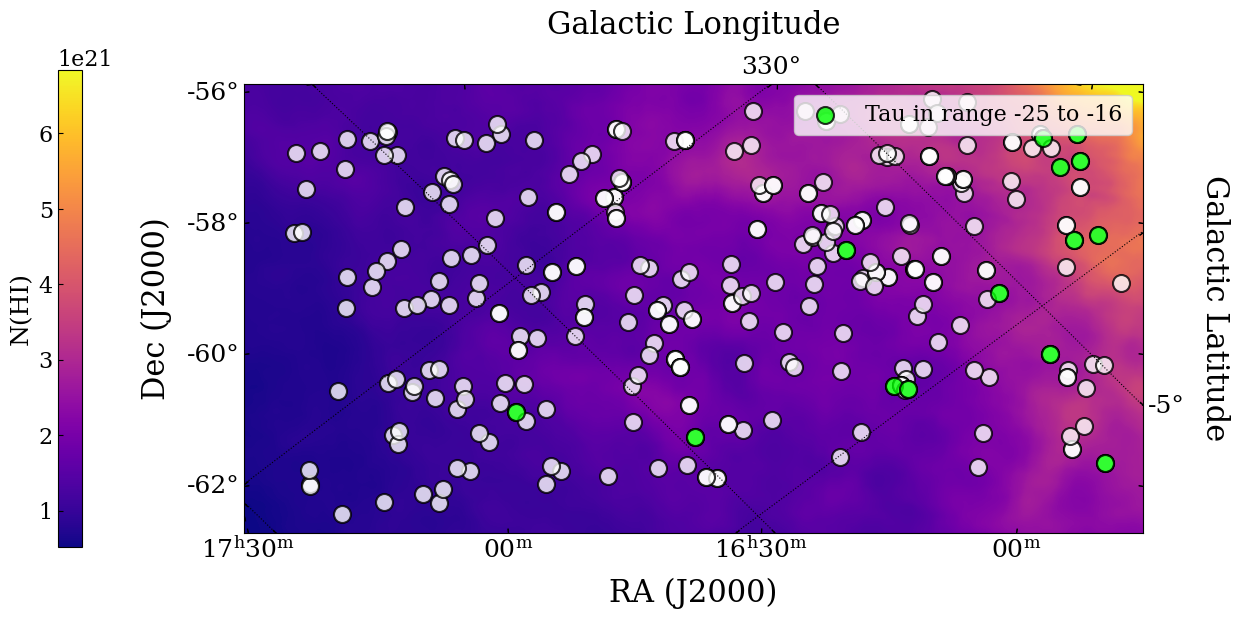

In [54]:
plot_continuum_tau(hdulist_hi_n, 
                   ra_deg_n_askap, 
                   dec_deg_n_askap, 
                   df_norma_askap['VLSR'], 
                   (-25,-16),
                   )

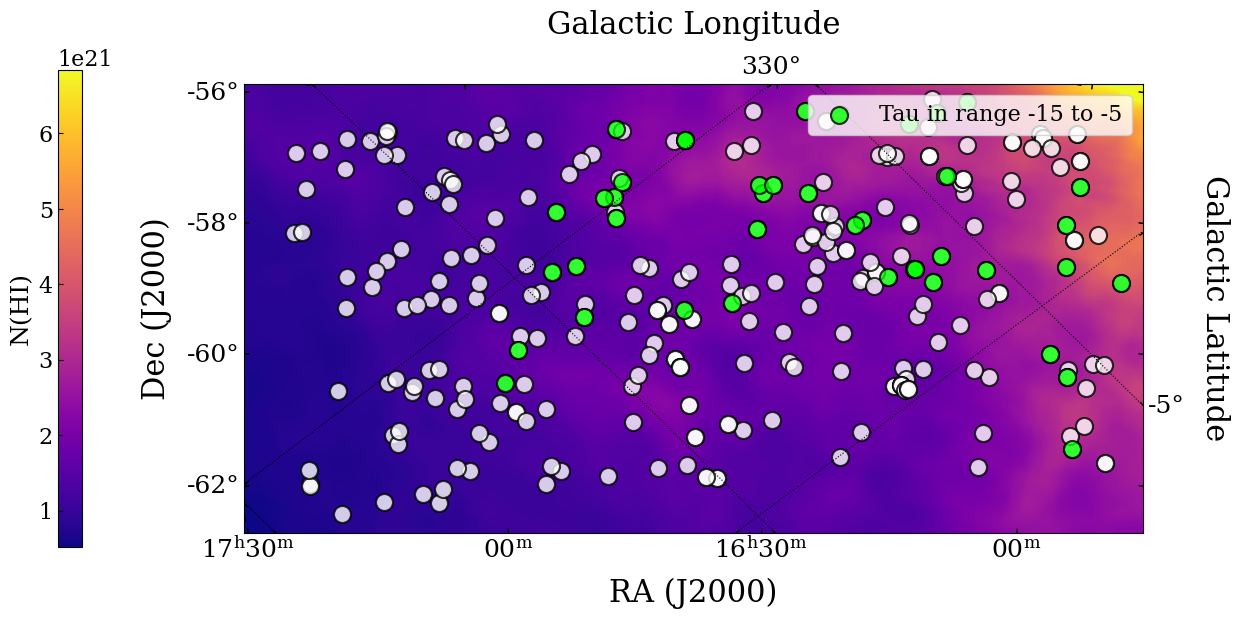

In [55]:
plot_continuum_tau(hdulist_hi_n, 
                   ra_deg_n_askap, 
                   dec_deg_n_askap, 
                   df_norma_askap['VLSR'], 
                   (-15,-5),
                   )

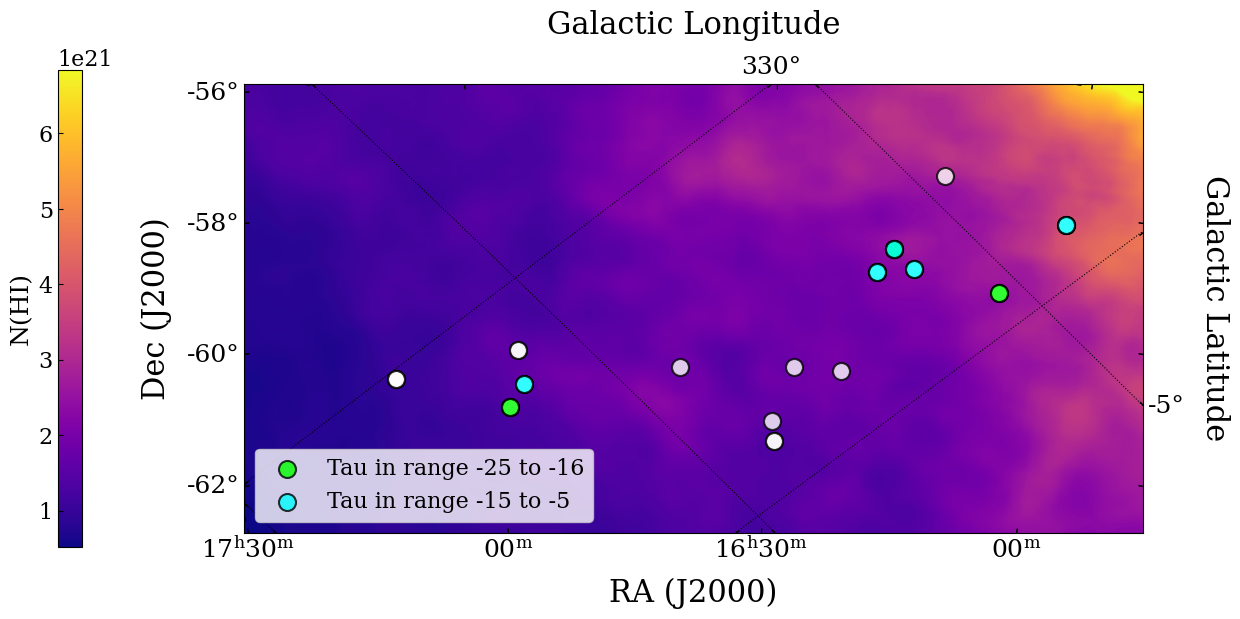

In [67]:
plot_continuum_tau_combined(hdulist_hi_n, 
                    ra_deg_nv2_atca_all, 
                    dec_deg_nv2_atca_all, 
                    df_normaV2_atca['VLSR'], 
                   (-25,-16),
                   (-15,-5),
                   )

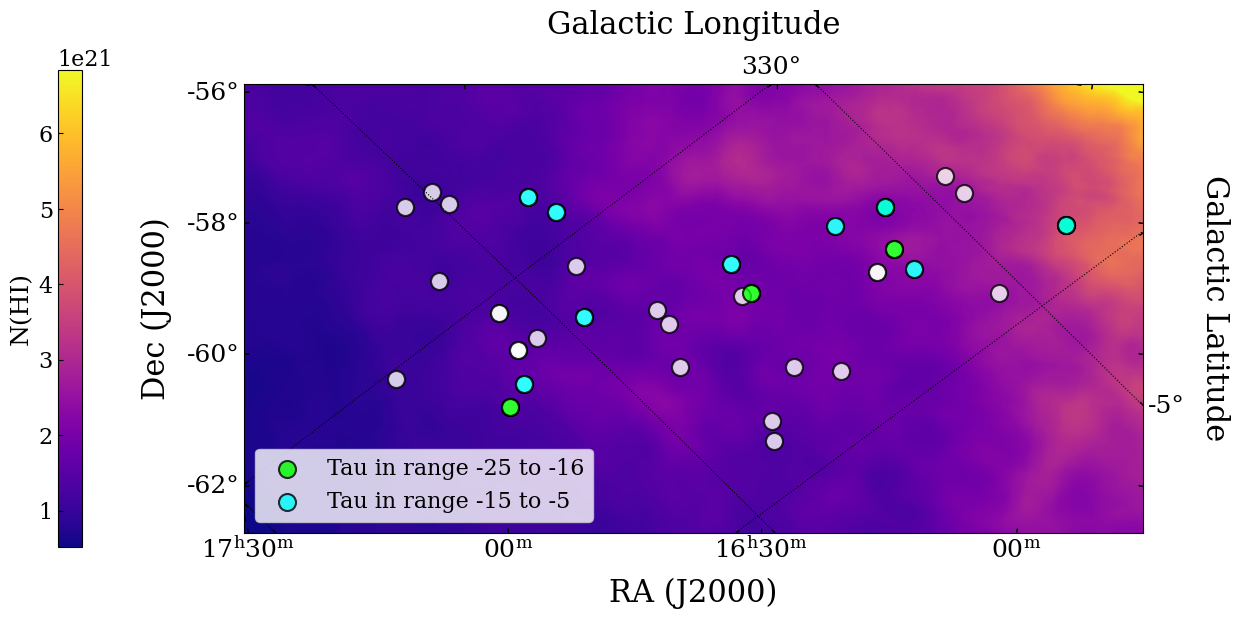

In [68]:
plot_continuum_tau_combined(hdulist_hi_n, 
                    ra_deg_n4k_atca_all, 
                    dec_deg_n4k_atca_all, 
                    df_norma4k_atca['VLSR'], 
                   (-25,-16),
                   (-15,-5),
                   )

In [72]:
def plot_continuum_tau_3d(hdulist_hi, ra_deg, dec_deg, tau, tau_range, elev=30, azim=-30, stl=r'$\tau$', xrot=0, yrot=0):
    """
    Plot 3D bars representing tau values at specific RA and Dec positions.
    Parameters:
    - hdulist_hi: HDU list from the FITS file.
    - ra_deg, dec_deg: RA and Dec positions of the sources.
    - tau: Tau values to be plotted.
    - tau_range: Range of tau values to be highlighted with a specific color.
    """
    # Extract data and header from the HI FITS file
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    
    # Create a 3D figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Set up WCS for 2D projection of the moment map
    wcs_2d = WCS(h)
    
    # Generate the meshgrid for the data
    ny, nx = d.shape
    x_idx, y_idx = np.meshgrid(np.arange(nx), np.arange(ny))
    
    # Convert the pixel coordinates to RA and Dec using WCS
    ra_map, dec_map = wcs_2d.wcs_pix2world(x_idx, y_idx, 1)
    
    # Adjust the scaling to maintain the rectangular aspect ratio
    aspect_ratio_x = (np.max(ra_map) - np.min(ra_map)) / (np.max(dec_map) - np.min(dec_map))
    
    # Normalize the tau values
    tau_normalized = tau / np.nanmax(tau)
    
    # Convert RA/Dec to pixel coordinates
    ra_pix, dec_pix = wcs_2d.wcs_world2pix(ra_deg, dec_deg, 1)
    
    # Contour plot for the moment map (HI data)
    ax.contourf(x_idx, y_idx, d, zdir='z', offset=0, alpha=1, cmap='plasma', zorder=1)
    
    # Plot 3D bars for tau values
    for i in range(len(tau)):
        # Determine color: white for all, lime for tau values in the specified range
        if tau_range[0] <= tau[i] <= tau_range[1]:
            color = 'lime'
        else:
            color = 'white'
        
        ax.bar3d(ra_pix[i], dec_pix[i], 0, dx=5*aspect_ratio_x, dy=10, dz=abs(tau[i]), color=color, zorder=2)
    
    # Set axis labels
    ax.set_xlabel('RA (J2000)', fontsize=14, labelpad=25)
    ax.set_ylabel('Dec (J2000)', fontsize=14, labelpad=25)
    ax.set_zlabel(stl, fontsize=14, labelpad=15)
    
    if hdulist_hi == hdulist_hi_n:
        ax.set_box_aspect([aspect_ratio_x*0.5, 1, 0.5])  # Adjust Z aspect as needed
    else:
        ax.set_box_aspect([aspect_ratio_x, 1, 0.5])  # Adjust Z aspect as needed
    
    # Set z-axis limits
    ax.set_zlim(0, np.nanmax(tau))
    
    # Set perspective view: adjust elevation and azimuth
    ax.view_init(elev=elev, azim=azim)
    
    # Add colorbar for the moment map
    mappable_d = plt.cm.ScalarMappable(cmap='plasma')
    mappable_d.set_array(d)
    fig.colorbar(mappable_d, ax=ax, shrink=0.4, pad=0.15, label='N(HI)')
    
    plt.show()


In [78]:
def plot_continuum_tau_3d_with_ranges(hdulist_hi, ra_deg, dec_deg, tau, tau_range_lime, tau_range_cyan, elev=30, azim=-30, stl=r'$\tau$', xrot=0, yrot=0):
    """
    Plot 3D bars representing tau values at specific RA and Dec positions.
    Parameters:
    - hdulist_hi: HDU list from the FITS file.
    - ra_deg, dec_deg: RA and Dec positions of the sources.
    - tau: Tau values to be plotted.
    - tau_range_lime: Range of tau values to be highlighted with lime color.
    - tau_range_cyan: Range of tau values to be highlighted with cyan color.
    """
    # Extract data and header from the HI FITS file
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    
    # Create a 3D figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Set up WCS for 2D projection of the moment map
    wcs_2d = WCS(h)
    
    # Generate the meshgrid for the data
    ny, nx = d.shape
    x_idx, y_idx = np.meshgrid(np.arange(nx), np.arange(ny))
    
    # Convert the pixel coordinates to RA and Dec using WCS
    ra_map, dec_map = wcs_2d.wcs_pix2world(x_idx, y_idx, 1)
    
    # Adjust the scaling to maintain the rectangular aspect ratio
    aspect_ratio_x = (np.max(ra_map) - np.min(ra_map)) / (np.max(dec_map) - np.min(dec_map))
    
    # Normalize the tau values
    tau_normalized = tau / np.nanmax(tau)
    
    # Convert RA/Dec to pixel coordinates
    ra_pix, dec_pix = wcs_2d.wcs_world2pix(ra_deg, dec_deg, 1)
    
    # Contour plot for the moment map (HI data)
    ax.contourf(x_idx, y_idx, d, zdir='z', offset=0, alpha=1, cmap='plasma', zorder=1)
    
    # Plot 3D bars for tau values
    for i in range(len(tau)):
        # Determine color: lime for tau_range_lime, cyan for tau_range_cyan, and white for others
        if tau_range_lime[0] <= tau[i] <= tau_range_lime[1]:
            color = 'lime'
        elif tau_range_cyan[0] <= tau[i] <= tau_range_cyan[1]:
            color = 'cyan'
        else:
            color = 'white'
        
        ax.bar3d(ra_pix[i], dec_pix[i], 0, dx=5*aspect_ratio_x, dy=10, dz=abs(tau[i]), color=color, zorder=2)
    
    # Set axis labels
    ax.set_xlabel('RA (J2000)', fontsize=14, labelpad=25)
    ax.set_ylabel('Dec (J2000)', fontsize=14, labelpad=25)
    ax.set_zlabel(stl, fontsize=14, labelpad=15)
    
    if hdulist_hi == hdulist_hi_n:
        ax.set_box_aspect([aspect_ratio_x*0.5, 1, 0.5])  # Adjust Z aspect as needed
    else:
        ax.set_box_aspect([aspect_ratio_x, 1, 0.5])  # Adjust Z aspect as needed
    
    
    # Set z-axis limits
    ax.set_zlim(0, np.nanmax(tau))
    
    # Set perspective view: adjust elevation and azimuth
    ax.view_init(elev=elev, azim=azim)
    
    # Add colorbar for the moment map
    mappable_d = plt.cm.ScalarMappable(cmap='plasma')
    mappable_d.set_array(d)
    fig.colorbar(mappable_d, ax=ax, shrink=0.4, pad=0.15, label='N(HI)')
    
    plt.show()


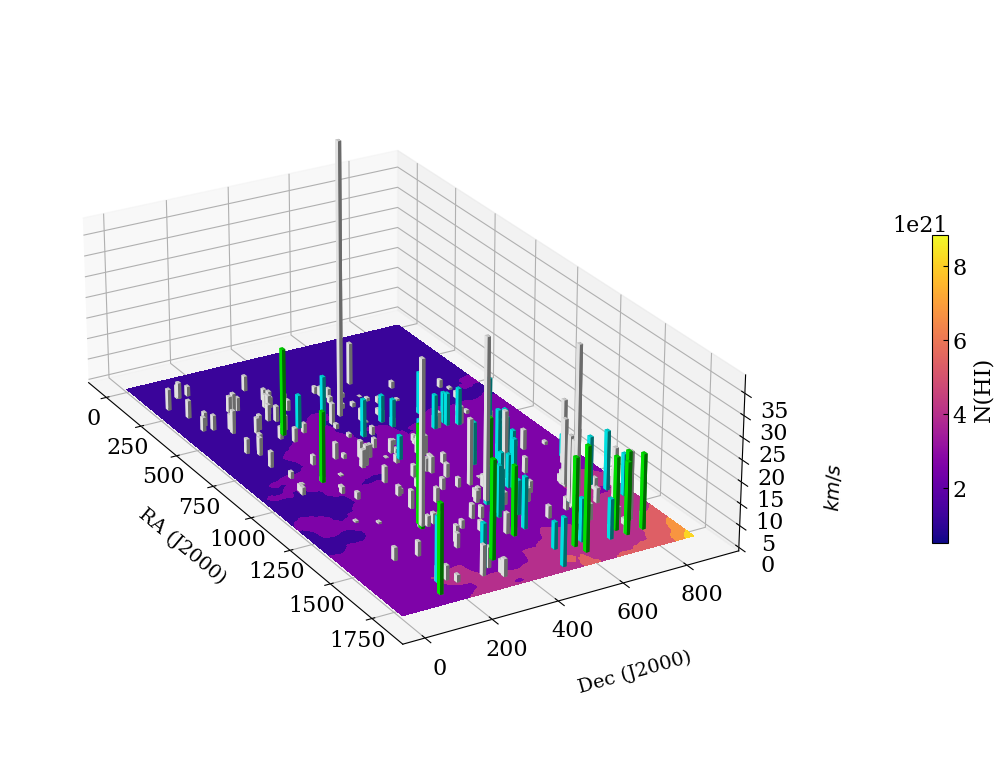

In [79]:
plot_continuum_tau_3d_with_ranges(hdulist_hi_n, 
                      ra_deg_n_askap, 
                      dec_deg_n_askap, 
                      df_norma_askap['VLSR'], 
                      (-25,-16),
                      (-15,-5),
                      elev=25, 
                      azim=-30,
                     stl = r'$km/s$')

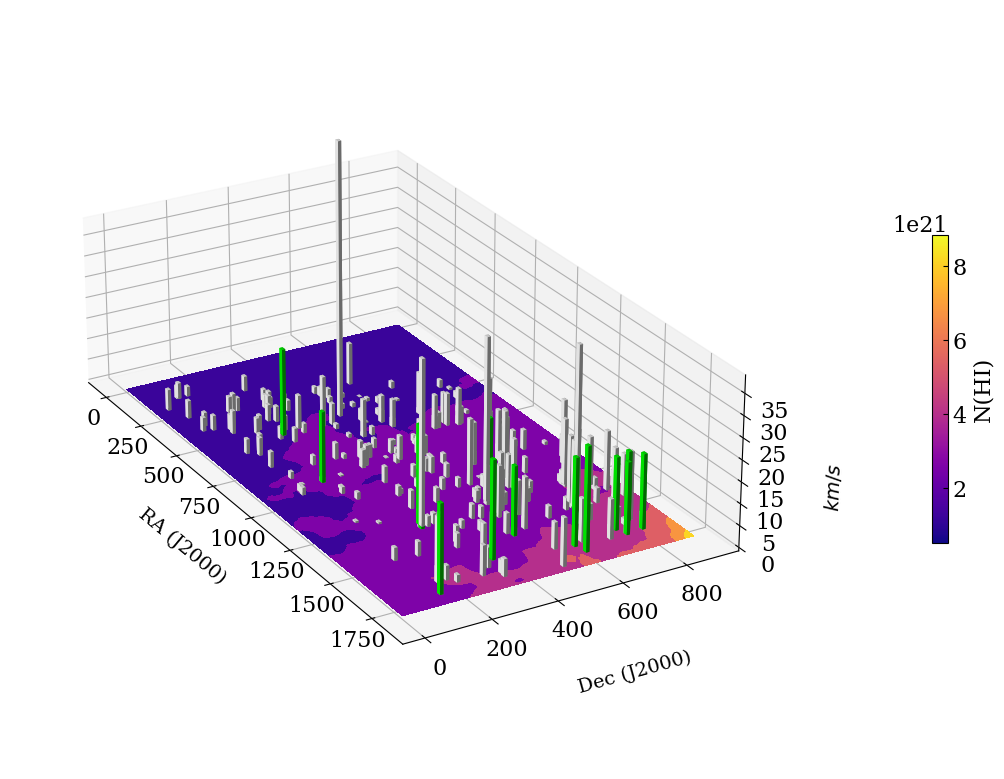

In [76]:
plot_continuum_tau_3d(hdulist_hi_n, 
                      ra_deg_n_askap, 
                      dec_deg_n_askap, 
                      df_norma_askap['VLSR'], 
                      (-25,-16),
                      elev=25, 
                      azim=-30,
                     stl = r'$km/s$')

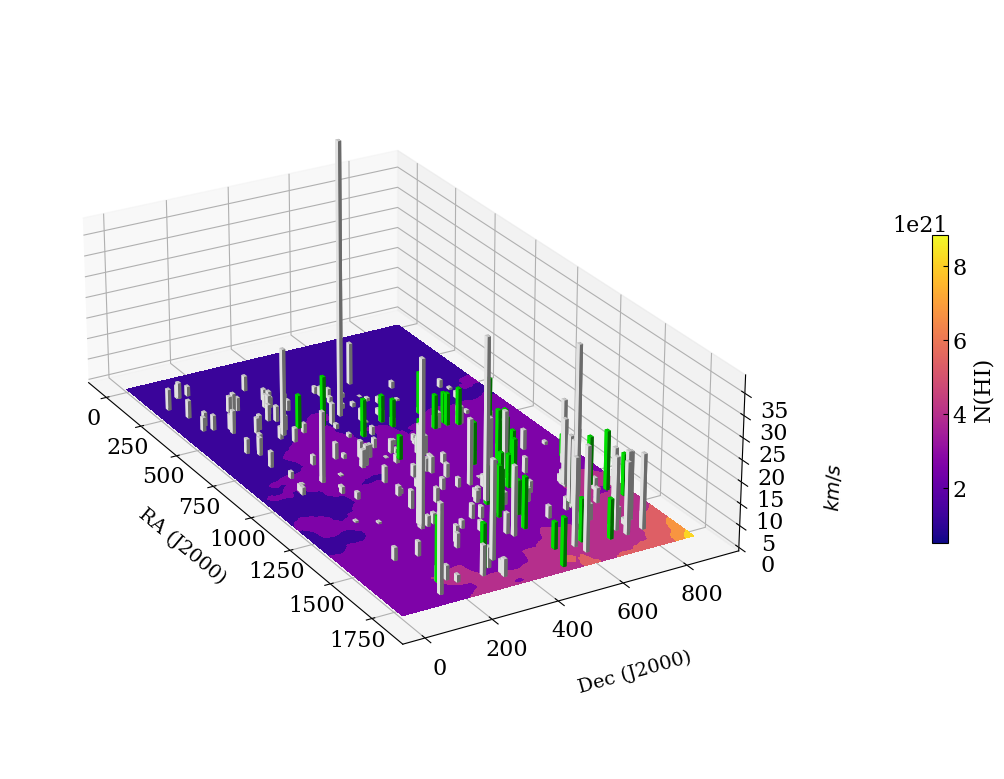

In [77]:
plot_continuum_tau_3d(hdulist_hi_n, 
                      ra_deg_n_askap, 
                      dec_deg_n_askap, 
                      df_norma_askap['VLSR'], 
                      (-15,-5),
                      elev=25, 
                      azim=-30,
                     stl = r'$km/s$')

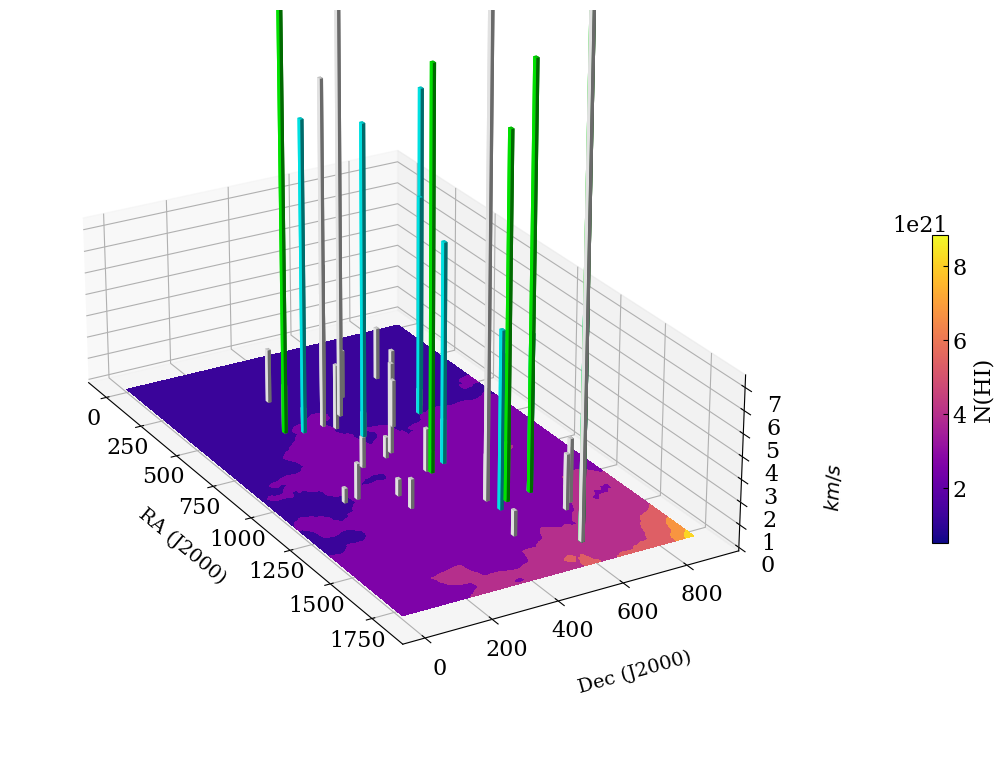

In [80]:
plot_continuum_tau_3d_with_ranges(hdulist_hi_n, 
                    ra_deg_n4k_atca_all, 
                    dec_deg_n4k_atca_all, 
                    df_norma4k_atca['VLSR'], 
                   (-25,-16),
                   (-15,-5),
                      elev=25, 
                      azim=-30,
                     stl = r'$km/s$')

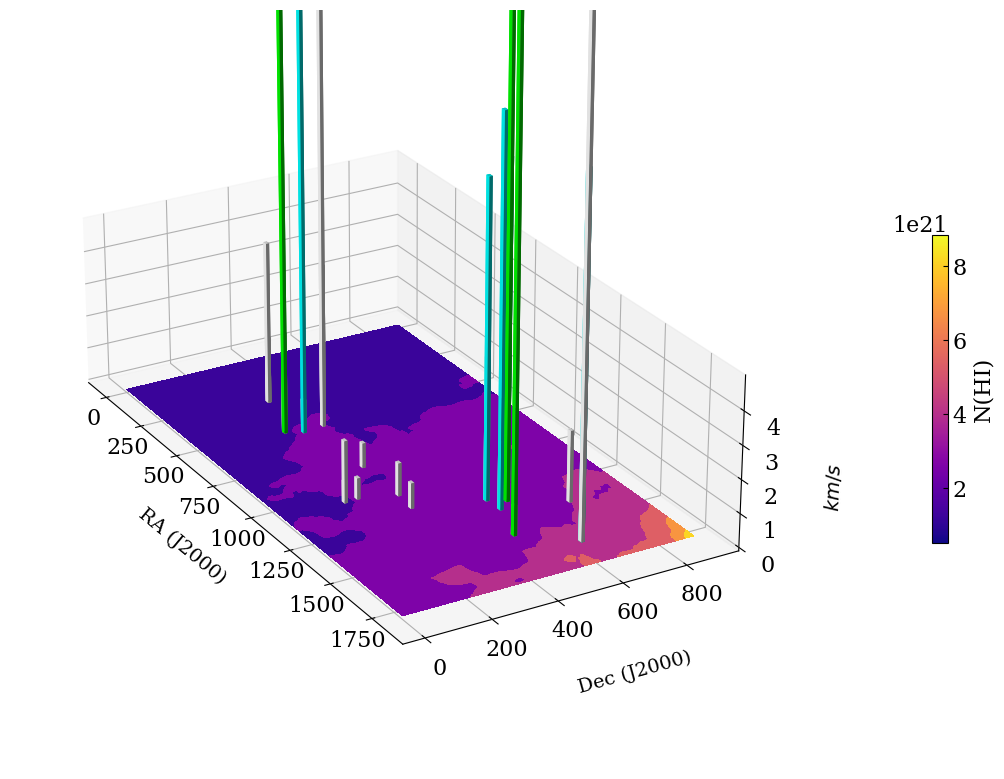

In [82]:
plot_continuum_tau_3d_with_ranges(hdulist_hi_n, 
                    ra_deg_nv2_atca_all, 
                    dec_deg_nv2_atca_all, 
                    df_normaV2_atca['VLSR'], 
                   (-25,-16),
                   (-15,-5),
                      elev=25, 
                      azim=-30,
                     stl = r'$km/s$')